# Music clustering

We'll be using a dataset from Spotify that contains metadata for songs on the platform to try and cluster songs that are closely related this is the underlying theory behind how recommender algorithms work on sites such as Spotify, Netflix, etc.

## Data Exploration

In [1]:
import os

# Charger le chemin depuis le fichier texte
with open(".path_repo.txt", "r") as f:
    path_repo = f.read().strip()

os.chdir(path_repo)

FileNotFoundError: [Errno 2] No such file or directory: '.path_repo.txt'

In [2]:
import pandas as pd
import pandas as pd

spotify_df = pd.read_csv('data\ML_spotify_data.csv')
spotify_df.head()

<>:4: SyntaxWarning: invalid escape sequence '\M'
<>:4: SyntaxWarning: invalid escape sequence '\M'
C:\Users\Vincent\AppData\Local\Temp\ipykernel_28228\4189815129.py:4: SyntaxWarning: invalid escape sequence '\M'
  spotify_df = pd.read_csv('data\ML_spotify_data.csv')


,name,artists,popularity,danceability,valence,energy,explicit,key,liveness,loudness,speechiness,tempo
0,We're For The Dark - Remastered 2010,['Badfinger'],22,0.678,0.559,0.432,0,3,0.0727,-12.696,0.0334,117.674
1,Sixty Years On - Piano Demo,['Elton John'],25,0.456,0.259,0.368,0,6,0.1560,-10.692,0.0280,143.783
2,Got to Find Another Way,['The Guess Who'],21,0.433,0.833,0.724,0,0,0.1700,-9.803,0.0378,84.341
3,Feelin' Alright - Live At The Fillmore East/1970,['Joe Cocker'],22,0.436,0.870,0.914,0,5,0.8550,-6.955,0.0610,174.005
4,Caravan - Take 7,['Van Morrison'],23,0.669,0.564,0.412,0,7,0.4010,-13.095,0.0679,78.716


For the purposes of our analyses, we will only need the numeric features from our dataset.

In [3]:
spotify_numeric = spotify_df.select_dtypes(include=['int64', 'float64'])

spotify_numeric.head()

,popularity,danceability,valence,energy,explicit,key,liveness,loudness,speechiness,tempo
0,22,0.678,0.559,0.432,0,3,0.0727,-12.696,0.0334,117.674
1,25,0.456,0.259,0.368,0,6,0.1560,-10.692,0.0280,143.783
2,21,0.433,0.833,0.724,0,0,0.1700,-9.803,0.0378,84.341
3,22,0.436,0.870,0.914,0,5,0.8550,-6.955,0.0610,174.005
4,23,0.669,0.564,0.412,0,7,0.4010,-13.095,0.0679,78.716


Spotify generate their own features that relate to abstract characteristcs that can be attributed to a piece of music (e.g. 'valence' or 'danceability').

Then we also have some information that is more literal such as the 'key', 'tempo' and whether a song is 'explicit' or not.

Let's investiate the distributions of some of our variables !

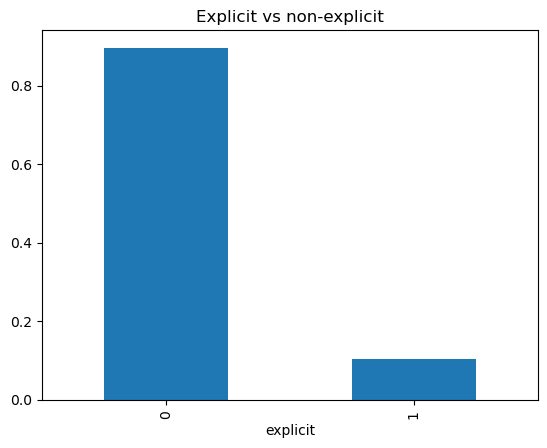

In [4]:
import matplotlib.pyplot as plt

spotify_numeric.explicit.value_counts(normalize=True).plot(kind='bar');
plt.title('Explicit vs non-explicit');

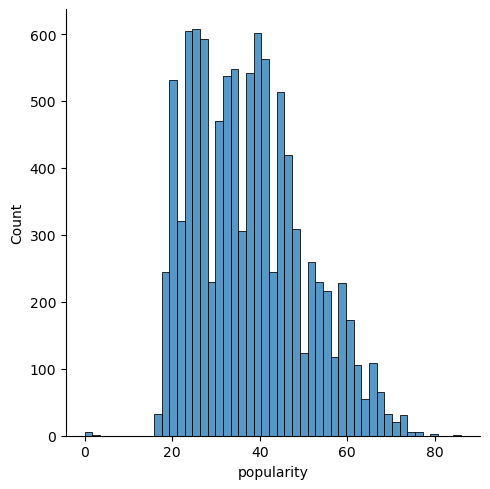

In [5]:
import seaborn as sns

sns.displot(spotify_numeric['popularity']);

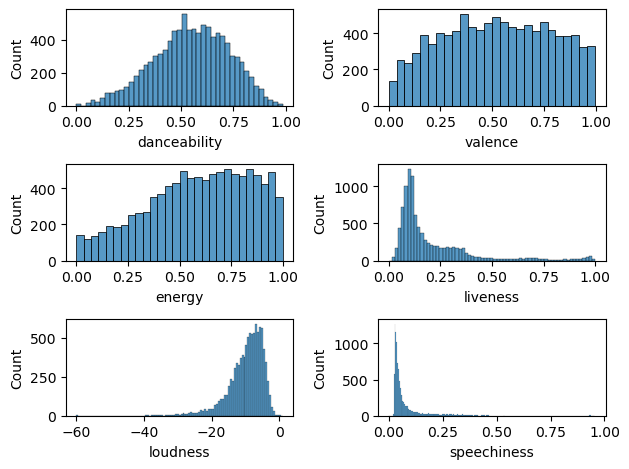

In [6]:
import numpy as np

fig, axs = plt.subplots(3, 2)

var_list = ['danceability', 'valence', 'energy', 'liveness', 'loudness', 'speechiness']

# Loop directly through the axs object and assign titles from the list
for row_axes, row_titles in zip(axs, np.array(var_list).reshape(3, 2)):
    for ax, title in zip(row_axes, row_titles):
        sns.histplot(x=spotify_numeric[title], ax=ax)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plots
plt.show()

Now let's visualize three of our features in 3D space.

In [7]:
import plotly.express as px

fig = px.scatter_3d(spotify_numeric,
                    x='danceability',
                    y='energy',
                    z='speechiness',
                    opacity=0.7,
                    width=500,
                    height=500
           )
fig.show()

## First model

Our goal is to cluster our songs into similar groups!

The plot above may not reveal clear clusters, but we can only visualize three of our variables at a time. There may be some clusters we haven't seen yet.

Let's start by instantiating a simple KMeans model with 8 clusters.

In [8]:
from sklearn.cluster import KMeans

kmeans_simple = KMeans(n_clusters=8, n_init='auto')
kmeans_simple.fit(spotify_numeric)

labels_simple = kmeans_simple.labels_

np.unique(labels_simple,return_counts=True)

c:\Users\Vincent\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning:

Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.

  File "c:\Users\Vincent\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "c:\Users\Vincent\anaconda3\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Vincent\anaconda3\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c:\Users\Vincent\anaconda3\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(

(array([0, 1, 2, 3, 4, 5, 6, 7]),
 array([ 721, 1072, 1785, 1357, 1423, 1260, 1548,  834], dtype=int64))

So we have our 8 clusters with between 803 and 1766 songs each.

We can also now visualise our songs in 3D space again, but this time colour them by our new labels to see what clusters we have created!

In [9]:
fig = px.scatter_3d(spotify_numeric,
                    x='danceability',
                    y='energy',
                    z='speechiness',
                    color=labels_simple,
                    width=500,
                    height=500)
fig.show()

It looks a little bit chaotic.
Let's try with some more preprocessing.

## Preprocessing

In [10]:
from sklearn.preprocessing import RobustScaler

scaler = RobustScaler()
spotify_scaled = pd.DataFrame(scaler.fit_transform(spotify_numeric),
                              columns=spotify_numeric.columns)
spotify_scaled

,popularity,danceability,valence,energy,explicit,key,liveness,loudness,speechiness,tempo
0,-0.736842,0.482072,0.080420,-0.475452,0.0,-0.285714,-0.336421,-0.626782,-0.270833,-0.015120
1,-0.578947,-0.402390,-0.618881,-0.640827,0.0,0.142857,0.161339,-0.307496,-0.395833,0.586217
2,-0.789474,-0.494024,0.719114,0.279070,0.0,-0.714286,0.244996,-0.165857,-0.168981,-0.782839
3,-0.736842,-0.482072,0.805361,0.770026,0.0,0.000000,4.338213,0.287899,0.368056,1.282283
4,-0.684211,0.446215,0.092075,-0.527132,0.0,0.285714,1.625336,-0.690353,0.527778,-0.912393
...,...,...,...,...,...,...,...,...,...,...
9995,1.894737,0.912351,0.194639,0.496124,0.0,0.285714,-0.279653,0.806182,0.995370,-0.306357
9996,1.684211,0.637450,0.488345,0.354005,0.0,0.285714,-0.167314,0.436868,0.356481,0.451550
9997,2.105263,0.306773,0.262238,0.625323,0.0,-0.142857,0.770840,1.041345,0.828704,-0.613624
9998,1.789474,0.454183,-0.768065,0.018088,1.0,-0.428571,3.071407,0.255078,6.085648,-0.996712


## Modelling with preprocessed data

Now, let's train and fit a model in the same way that we did above. However, this time we will use the scaled data!

In [11]:
kmeans_scaled = KMeans(n_clusters=8, n_init='auto')
kmeans_scaled.fit(spotify_scaled)

labels_scaled = kmeans_scaled.labels_
np.unique(labels_scaled,return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7]),
 array([2211,  714,  487, 2515, 1458,  857,   57, 1701], dtype=int64))

In [12]:
fig_scaled = px.scatter_3d(spotify_scaled,
                           x='danceability',
                           y='energy',
                           z='speechiness',
                           color=labels_scaled,
                           width=500,
                           height=500)
fig_scaled.show()

## Finding the right value for *K*

It's look a bit better, but we are only looking at 3 dimensions out of the 10 dimensions that our model is trained on.

It might be that, if we could visualise 10 dimensionsal space, we would see some much more intuitively shaped clusters!

So far we have been using 8 clusters for our models so far, but we havented tested whether this makes sense.

Let's use *the elbow method* to check how many of clusters we should ideally be using for this dataset. Do this below. Remember to use a plot to visualise your results.

In [13]:
nb_clusters_to_try = np.arange(1, 21, 1)
nb_clusters_to_try

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20])

In [14]:
inertias = []

for k in nb_clusters_to_try:
    kmeans = KMeans(n_clusters=k, n_init='auto')
    kmeans.fit(spotify_scaled)
    inertias.append(kmeans.inertia_)

inertias

[100388.99587726688,
 63515.00771185543,
 55856.55231080803,
 47978.30998904283,
 38653.08506681646,
 35058.70668057669,
 32597.686297087486,
 31038.56417375336,
 29592.406837438226,
 28227.03286397688,
 26845.378153805348,
 26205.65974227228,
 25642.166199618518,
 24874.043691631192,
 24668.63178231689,
 24157.241464843686,
 23677.31137807809,
 23067.771092278403,
 22841.51075179779,
 22358.070721728305]

In [15]:
import plotly.express as px

fig = px.line(y=inertias,
              x=range(1, len(inertias) + 1),
              labels={'x': 'nb centroids', 'y':'Inertia'},
              title="Elbow method")
fig.show()

It looks as though have around 6 clusters makes sense with our dataset. So let's create a new KMeans model using 6 clusters and plot it in 3D space using the same process that we have done above.

## Creating a model with the ideal number of clusters

In [16]:
spotify_clusters = 6

kmeans = KMeans(n_clusters=spotify_clusters, n_init='auto', max_iter=300)

kmeans.fit(spotify_scaled)

labelling = kmeans.labels_

fig_scaled = px.scatter_3d(spotify_scaled,
                           x='danceability',
                           y='energy',
                           z='speechiness',
                           color=labels_scaled,
                           width=500,
                           height=500)
fig_scaled.show()

The chart doesn't reveal a whole lot more, but perhaps we can create some theoretical playlists based on our clusters?

Let's add the new labels from our model that has 6 clusters to our original spotify dataframe as a column called 'label'.

In [17]:
spotify_df['label'] = pd.Series(labelling)

spotify_df.head()

,name,artists,popularity,danceability,valence,energy,explicit,key,liveness,loudness,speechiness,tempo,label
0,We're For The Dark - Remastered 2010,['Badfinger'],22,0.678,0.559,0.432,0,3,0.0727,-12.696,0.0334,117.674,5
1,Sixty Years On - Piano Demo,['Elton John'],25,0.456,0.259,0.368,0,6,0.1560,-10.692,0.0280,143.783,2
2,Got to Find Another Way,['The Guess Who'],21,0.433,0.833,0.724,0,0,0.1700,-9.803,0.0378,84.341,5
3,Feelin' Alright - Live At The Fillmore East/1970,['Joe Cocker'],22,0.436,0.870,0.914,0,5,0.8550,-6.955,0.0610,174.005,3
4,Caravan - Take 7,['Van Morrison'],23,0.669,0.564,0.412,0,7,0.4010,-13.095,0.0679,78.716,5


## Generating Spotify playlists based on our clusters!

We should now see the original meta-data for our spotify songs, but **with the added label of which cluster they are located in** based on our KMeans algorithm

Let's generate 6 playlists (one for each cluster) that contains 15 random songs from that cluster.

In [18]:
daily_mixes = {}

for num_cluster in np.unique(labelling):

  daily_mixes[num_cluster] = spotify_df[spotify_df['label'] == num_cluster]

Run the cell below to print out our 6 playlists!!!

In [19]:
for key,value in daily_mixes.items():
  print("-" * 50)
  print(f"Here are some songs for playlist {key}")
  print("-" * 50)
  display(value.sample(5)[['name', 'artists']])

--------------------------------------------------
Here are some songs for playlist 0
--------------------------------------------------


,name,artists
9519,Mileage (feat. Chief Keef),"['Playboi Carti', 'Chief Keef']"
7865,I Like To Move It,['Madagascar 5']
4578,Room for One More,['Anthrax']
6119,Take Lots with Alcohol,['Alkaline Trio']
5421,Manic Depression,['Jimi Hendrix']


--------------------------------------------------
Here are some songs for playlist 1
--------------------------------------------------


,name,artists
9823,Only You Freestyle,"['Headie One', 'Drake']"
6666,Nic's Groove,['The Foreign Exchange']
6238,Scary Moves,['Bad Meets Evil']
5893,Where Have You Been,"['JAY-Z', 'Beanie Sigel']"
4689,One Time 4 Your Mind,['Nas']


--------------------------------------------------
Here are some songs for playlist 2
--------------------------------------------------


,name,artists
5951,Tonight May Have To Last Me All My Life,['The Avalanches']
3448,Lovers Game,['Chris Isaak']
4604,The Sacrifice,['Michael Nyman']
3349,"Mazurka in G Minor, Op.67, No.2","['Frédéric Chopin', 'Vladimir Ashkenazy']"
1486,The Bricklayer's Beautiful Daughter,['Will Ackerman']


--------------------------------------------------
Here are some songs for playlist 3
--------------------------------------------------


,name,artists
8960,No Less,"['SG Lewis', 'Louis Mattrs']"
737,"Like a Rolling Stone - Live at LA Forum, Ingle...",['Bob Dylan']
593,Falling - Live April 1972 At Sigma Sound Studi...,['Billy Joel']
1333,Easy - Live / 1977,['Commodores']
1025,Saaltak Habiby,['Fairuz']


--------------------------------------------------
Here are some songs for playlist 4
--------------------------------------------------


,name,artists
1419,Announcement - Live,['Townes Van Zandt']
1822,Hollywood Casting Session,['Robin Williams']
9959,When We Shoot,['Lil Durk']
7775,Chase Through the Subway,['John Mulaney']
7563,Things We Say When People Die,['George Carlin']


--------------------------------------------------
Here are some songs for playlist 5
--------------------------------------------------


,name,artists
6267,Don't Stand So Close To Me,['The Police']
6443,Walking in Memphis,['Lonestar']
1802,Ladies Man,['April Wine']
5807,Selfish Man,['Flogging Molly']
3077,(She Was A) Hotel Detective,['They Might Be Giants']
